In [1]:
import sys
sys.path.append("../models/pytorch-CycleGAN-and-pix2pix/")

import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2


# Prepare train and test files & directories

In [2]:
in_dir  = "/home/data/world-cities/urban_areas_over_10kpop_log"
val_dir = "/home/data/world-cities/urban_areas_over_10kpop_pruned_log/"
out_dir = "/home/data/world-cities/top10k-log/"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [3]:
import re
def parse_list(s):
    s = re.sub('\s+', ' ', s[1:-1]).strip().replace(",",' ')
    s = re.sub('\s+', ' ', s)
    # print s.split(" ")
    if len(s.split(" "))>0:
        ret = [float(n.strip()) for n in s.split(" ")]
    return ret

#### Load file paths

In [57]:
# load stats on SAR data
sar_files_df = pd.read_csv("/home/data/world-cities/urban_areas_over_10kpop_stats.csv").drop("Unnamed: 0", 1)
sar_files_df['basename'] = sar_files_df['filename'].apply(lambda s: "_".join(os.path.basename(s).split("_")[1:]))

# assign a shorter ID to each sample
sar_files_df['index'] = sar_files_df.index

# only retain data with enough signal
sar_files_df = sar_files_df[sar_files_df['build pct 286']>=0.02]

sar_files_df.head()


,filename,class,country,population,city,region,source,build pct 128,patch distr 128,top patch areas 128,...,fractal dim 286,box counts 286,build pct 64,patch distr 64,top patch areas 64,fractal dim 64,box counts 64,decile,basename,index
0,/home/data/world-cities/urban_areas_over_10kpo...,very-small,us,44071,"saint louis park, us (pop 44.1k)",Americas,SAR,0.047048,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 12. 6. 5. 3. 2. 2. 2. 2. 2. ...,...,1.377339,[ 1.38629436 2.19722458 3.21887582 4.356708...,0.046378,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 9. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. ...,1.096326,[ 0. 1.38629436 1.79175947 2.397895...,6,"us_saint-louis-park,-us-(pop-44.1k)_very-small...",0
9,/home/data/world-cities/urban_areas_over_10kpo...,very-small,th,31153,"bang sao thong, th (pop 31.2k)",Asia,SAR,0.089941,[ 0.69314718 0. 0. 0. ...,[ 45. 9. 6. 5. 4. 3. 3. 2. 2. ...,...,1.465261,[ 1.38629436 2.19722458 3.17805383 4.234106...,0.089634,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 16. 1. 1. 1. 1. 1. 1. 1. 1. ...,1.515565,[ 0. 1.38629436 2.48490665 3.135494...,8,"th_bang-sao-thong,-th-(pop-31.2k)_very-small_3...",9
10,/home/data/world-cities/urban_areas_over_10kpo...,very-small,nl,19806,"borne, nl (pop 19.8k)",Europe,SAR,0.115364,[ 1.38629436 1.38629436 0. 0. ...,[ 6. 5. 4. 4. 4. 4. 3. 3. 3. 3. 2. ...,...,1.625747,[ 1.38629436 2.19722458 3.21887582 4.394449...,0.116120,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1.901728,[ 0. 1.38629436 2.77258872 3.931825...,9,"nl_borne,-nl-(pop-19.8k)_very-small_19806_52.3...",10
11,/home/data/world-cities/urban_areas_over_10kpo...,small,de,84209,"wilhelmshaven, de (pop 84.2k)",Europe,SAR,0.047996,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 4. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,...,1.482856,[ 1.38629436 2.19722458 3.13549422 4.158883...,0.046528,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 2. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. ...,1.396921,[ 0. 1.38629436 2.39789527 2.890371...,6,"de_wilhelmshaven,-de-(pop-84.2k)_small_84209_5...",11
16,/home/data/world-cities/urban_areas_over_10kpo...,very-small,ch,23756,"yverdon, ch (pop 23.8k)",Europe,SAR,0.051776,[ 1.09861229 0. 0. 0. ...,[ 5. 3. 3. 3. 2. 2. 1. 1. 1. 1. 1. ...,...,1.519127,[ 1.38629436 2.19722458 3.21887582 4.382026...,0.051951,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 3. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. ...,1.318010,[ 0. 1.38629436 2.39789527 2.708050...,7,"ch_yverdon,-ch-(pop-23.8k)_very-small_23756_46...",16


In [58]:
import glob

# train + test files

files = glob.glob(in_dir + "/PNM*.png") 
files_df = pd.DataFrame(files, columns=["filename"])
files_df['basename'] = files_df['filename'].apply(lambda s: "_".join(os.path.basename(s).split("_")[1:]))
print len(files_df)

# validation files

files_valid = glob.glob(in_dir + "/PNM*.png") 
files_valid_df = pd.DataFrame(files_valid, columns=["filename"])
files_valid_df['basename'] = files_valid_df['filename'].apply(lambda s: "_".join(os.path.basename(s).split("_")[1:]))
print len(files_df)

25024

25024

In [59]:
myfiles_df = pd.merge(sar_files_df, files_df, on="basename", how="left", 
                      suffixes=["_SAR", "_PNM"])
myfiles_df.shape

(9916, 26)

In [60]:
cols_to_parse = ["patch distr", "top patch areas", "box counts"]
for c in myfiles_df.columns:
    if len([x for x in cols_to_parse if x in c])>0:
        myfiles_df[c] = myfiles_df[c].apply(parse_list)
myfiles_df.head(2)

,filename_SAR,class,country,population,city,region,source,build pct 128,patch distr 128,top patch areas 128,...,box counts 286,build pct 64,patch distr 64,top patch areas 64,fractal dim 64,box counts 64,decile,basename,index,filename_PNM
0,/home/data/world-cities/urban_areas_over_10kpo...,very-small,us,44071,"saint louis park, us (pop 44.1k)",Americas,SAR,0.047048,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[12.0, 6.0, 5.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",...,"[1.38629436, 2.19722458, 3.21887582, 4.3567088...",0.046378,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.096326,"[0.0, 1.38629436, 1.79175947, 2.39789527, 2.89...",6,"us_saint-louis-park,-us-(pop-44.1k)_very-small...",0,/home/data/world-cities/urban_areas_over_10kpo...
1,/home/data/world-cities/urban_areas_over_10kpo...,very-small,th,31153,"bang sao thong, th (pop 31.2k)",Asia,SAR,0.089941,"[0.69314718, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[45.0, 9.0, 6.0, 5.0, 4.0, 3.0, 3.0, 2.0, 2.0,...",...,"[1.38629436, 2.19722458, 3.17805383, 4.2341065...",0.089634,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[16.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1.515565,"[0.0, 1.38629436, 2.48490665, 3.13549422, 3.68...",8,"th_bang-sao-thong,-th-(pop-31.2k)_very-small_3...",9,/home/data/world-cities/urban_areas_over_10kpo...


In [61]:
# select training and testing examples

train_df = myfiles_df.sample(int(len(myfiles_df)*0.8))
test_df  = myfiles_df[~myfiles_df.index.isin(train_df.index)]

train_df.shape, test_df.shape

((7932, 26), (1984, 26))

#### Save dataset info to file

In [63]:
train_df.drop("filename_SAR",1)\
    .rename(columns={"filename_PNM":"filename"})\
    .to_csv(out_dir + "/trainA.csv")
    
test_df.drop("filename_SAR",1)\
    .rename(columns={"filename_PNM":"filename"})\
    .to_csv(out_dir + "/testA.csv")
    
train_df.drop("filename_PNM",1)\
    .rename(columns={"filename_SAR":"filename"})\
    .to_csv(out_dir + "/trainB.csv")
    
test_df.drop("filename_PNM",1)\
    .rename(columns={"filename_SAR":"filename"})\
    .to_csv(out_dir + "/testB.csv")
    
train_df.to_csv(out_dir + "/train.csv")
test_df.to_csv(out_dir + "/test.csv")

#### Construct train and test datasets: folder version

In [64]:
train_dirA = out_dir + "/trainA"
train_dirB = out_dir + "/trainB"
test_dirA  = out_dir + "/testA"
test_dirB  = out_dir + "/testB"

if not os.path.exists(train_dirA):
    os.makedirs(train_dirA)
if not os.path.exists(train_dirB):
    os.makedirs(train_dirB)
if not os.path.exists(test_dirA):
    os.makedirs(test_dirA)
if not os.path.exists(test_dirB):
    os.makedirs(test_dirB)


In [65]:
# input domain A: population, nightlights, water mask (PNM)

for f in train_df['filename_PNM']:
    os.symlink(f, train_dirA + "/" + os.path.basename(f))
    
for f in test_df['filename_PNM']:
    os.symlink(f, test_dirA + "/" + os.path.basename(f))

# target domain B: SAR

for f in train_df['filename_SAR']:
    os.symlink(f, train_dirB + "/" + os.path.basename(f))

for f in test_df['filename_SAR']:
    os.symlink(f, test_dirB + "/" + os.path.basename(f))


In [17]:

from skimage.io import imread

f_SAR = train_df['filename_SAR'].iloc[130]
imgSAR = imread(f_SAR)

f_PNM = train_df['filename_PNM'].iloc[130]
imgPNM = imread(f_PNM)


In [18]:
imgSAR.shape, imgPNM.shape

((286, 286), (286, 286, 3))

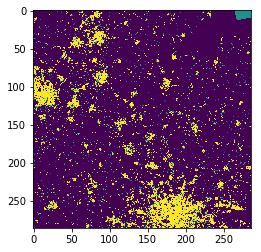

In [19]:
plt.imshow(imgSAR)

In [28]:
tmp = imgPNM[:,:,0].reshape(imgPNM.shape[0], imgPNM.shape[1], 1).transpose([2,0,1])

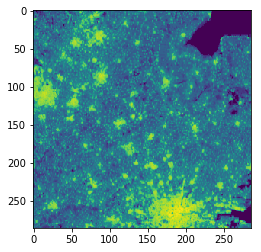

In [37]:
plt.imshow(tmp.squeeze())

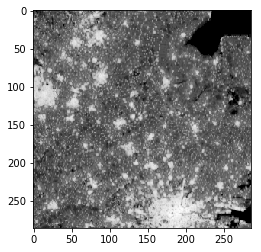

In [39]:
plt.imshow(tmp.repeat(3,0).transpose([1,2,0]))

In [44]:
from PIL import Image

def save_image(image_numpy, image_path):
    if len(image_numpy.squeeze())<3:
        image_numpy = (((image_numpy - image_numpy.min()) / (image_numpy.max() - image_numpy.min())) * 255.9).astype(np.uint8)
    image_pil = Image.fromarray(image_numpy)
    image_pil.save(image_path)


In [52]:
tmp.transpose([1,2,0]).dtype, tmp.dtype

(dtype('uint8'), dtype('uint8'))

In [55]:
import visdom
vis = visdom.Visdom()

In [56]:
vis.

u'main'

# Test data loader from csv/dataframe

In [81]:
import sys
sys.path.append("./../pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader, default_loader, fn_rotate, make_dataset
import torchvision.transforms as transforms
import torch

In [85]:
label_columns = ["region", "build pct 286", "fractal dim 286", "top patch areas 286"]

train_csv = out_dir + "/train.csv"
train_dataset = ImageDataFrame(df=train_csv, #train_df, 
                               filenameCol=["filename_PNM", "filename_SAR"],
                               return_paths=True,
                               label_columns=label_columns,
                               loader=[default_loader, grayscale_loader],
                               transform=transforms.Compose([
                                   transforms.RandomHorizontalFlip(),
                                   transforms.Lambda(lambda img: fn_rotate(img, 20)),
                                   transforms.Scale(256),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0, 0, 0), (255.0, 255.0, 255.0))
                           ]))

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=4,
                                               shuffle=True, 
                                               num_workers=2)

loading from file /home/data/world-cities/top10k-log//train.csv


In [79]:
"|".join(label_columns)

'region|build pct 286|fractal dim 286|top patch areas 286'

In [ ]:
imgs = make_dataset(train_df, filenameCol=["filename_SAR", "filename_PNM"], 
             label_columns=label_columns)

In [ ]:
imgs[0][0]

In [83]:
for i, data in enumerate(train_dataloader):
    images, labels, paths = data
    if i>3:
        break

In [88]:
labels[]


1.00000e-02 *
  3.7936
  5.4208
  4.6946
  6.6923
[torch.DoubleTensor of size 4]

In [ ]:
(imgSAR,) + (imgPNM,) + (labels,)

In [ ]:
torch.cat(labels[3]).view(-1,4)

In [72]:
np.array([[0.2]]).squeeze(0)

array([ 0.2])